# Evaluating Azure AI Search with LlamaIndex and TruLens

This notebook provides a comprehensive guide on how to create an index using [Azure AI Search](https://learn.microsoft.com/azure/search/), [LlamaIndex](https://docs.llamaindex.ai/stable/), [Azure OpenAI](https://learn.microsoft.com/azure/ai-services/openai/), and [TruLens](https://www.trulens.org/). The goal is to build a robust Retrieval-Augmented Generation (RAG) Evaluation system.

## Overview

RAG has become a standard architecture for equipping Large Language Models (LLMs) with context, thereby reducing the occurrence of hallucinations. However, even RAGs can experience hallucinations when the retrieval fails to provide sufficient or relevant context. 

To address this, we use TruLens's [RAG Triad](https://www.trulens.org/trulens_eval/getting_started/core_concepts/rag_triad/) for evaluating the quality of both retrieval and generation in the RAG architecture. The RAG Triad consists of:

1. **Context Relevance**: This ensures that each piece of context is relevant to the input query.
2. **Groundedness**: This verifies that the response is based on the retrieved context and not on hallucinations.
3. **Answer Relevance**: This ensures that the response accurately answers the original question.

By achieving satisfactory evaluations on these three aspects, we can ensure the correctness of our application and minimize hallucinations within the limits of its knowledge base.

## Setting Up a Python Virtual Environment in Visual Studio Code
1. Open the Command Palette (`Ctrl+Shift+P`).
2. Search for `Python: Create Environment`.
3. Select `Venv`.
4. Select a Python interpreter. Choose 3.10 or later.

> Note: The setup can take a minute. If you encounter any issues, refer to [Python environments in VS Code](https://code.visualstudio.com/docs/python/environments).

Run the following commands to install the required packages:

```python
!pip install llama-index
!pip install azure-identity
!pip install python-dotenv
!pip install trulens-eval
!pip install llama-index-vector-stores-azureaisearch
!pip install azure-search-documents --pre 

## Initial Setup
Load environment variables and initialize the necessary clients and models.

In [18]:
import os
from dotenv import load_dotenv
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
from llama_index.core import SimpleDirectoryReader, StorageContext, VectorStoreIndex
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.vector_stores.azureaisearch import AzureAISearchVectorStore, IndexManagement

# Load environment variables
load_dotenv()

# Environment Variables
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME") # I'm using GPT-3.5-turbo
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME") # I'm using text-embedding-ada-002
SEARCH_SERVICE_ENDPOINT = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
SEARCH_SERVICE_API_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")
INDEX_NAME = "contoso-hr-docs"

# Initialize Azure OpenAI and embedding models
llm = AzureOpenAI(
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-02-01"
)

embed_model = AzureOpenAIEmbedding(
    model=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-02-01"
)

# Initialize search clients
credential = AzureKeyCredential(SEARCH_SERVICE_API_KEY)
index_client = SearchIndexClient(endpoint=SEARCH_SERVICE_ENDPOINT, credential=credential)
search_client = SearchClient(endpoint=SEARCH_SERVICE_ENDPOINT, index_name=INDEX_NAME, credential=credential)


## Vector Store Initialization
Set up the vector store using Azure AI Search.

In [19]:
from llama_index.core.settings import Settings

Settings.llm = llm
Settings.embed_model = embed_model

# Initialize the vector store
vector_store = AzureAISearchVectorStore(
    search_or_index_client=index_client,
    index_name=INDEX_NAME,
    index_management=IndexManagement.CREATE_IF_NOT_EXISTS,
    id_field_key="id",
    chunk_field_key="text",
    embedding_field_key="embedding",
    embedding_dimensionality=1536,
    metadata_string_field_key="metadata",
    doc_id_field_key="doc_id",
    language_analyzer="en.lucene",
    vector_algorithm_type="exhaustiveKnn",
)


## Load Documents and Create Vector Store Index
Load documents from the specified directory and create a vector store index.

In [20]:
import nest_asyncio
from llama_index.core.extractors import TitleExtractor, QuestionsAnsweredExtractor
from llama_index.core.node_parser import TokenTextSplitter

nest_asyncio.apply()

# Configure text splitter
text_splitter = TokenTextSplitter(separator=" ", chunk_size=512, chunk_overlap=128)

# Load documents
documents = SimpleDirectoryReader("data/pdf").load_data()
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# Create index
index = VectorStoreIndex.from_documents(documents, transformations=[text_splitter], storage_context=storage_context)


## Query Execution
Execute a query to test the setup.

In [9]:
# Query execution
query = "Does my health plan cover scuba diving?"
query_engine = index.as_query_engine(llm, similarity_top_k=3)
response = query_engine.query(query)

# Print the response
print(response)

Your health plan may not cover scuba diving, as it is important to review the plan's evidence of coverage to ensure that the service or treatment is covered under the plan. Additionally, it is advisable to discuss the service or treatment with your doctor to ensure that it is medically necessary. If scuba diving is not covered under the plan, you should discuss payment options with your doctor or healthcare provider, and consider other payment sources such as private insurance, flexible spending accounts, or state or federal programs.


## Compare Different Query Engines
Evaluate and compare the responses from different query engines.

In [21]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.vector_stores.types import VectorStoreQueryMode

# Initialize retrievers and query engines
keyword_retriever = index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.SPARSE, similarity_top_k=10)
hybrid_retriever = index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.HYBRID, similarity_top_k=10)
semantic_hybrid_retriever = index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.SEMANTIC_HYBRID, similarity_top_k=10)

keyword_query_engine = RetrieverQueryEngine(retriever=keyword_retriever)
hybrid_query_engine = RetrieverQueryEngine(retriever=hybrid_retriever)
semantic_hybrid_query_engine = RetrieverQueryEngine(retriever=semantic_hybrid_retriever)

# Query and print responses
for engine_name, engine in zip(['Keyword', 'Hybrid', 'Semantic Hybrid'], 
                               [keyword_query_engine, hybrid_query_engine, semantic_hybrid_query_engine]):
    response = engine.query(query)
    print(f"{engine_name} Response:", response)
    print(f"{engine_name} Source Nodes:")
    for node in response.source_nodes:
        print(node)
    print("\n")


Keyword Response: Your health plan covers scuba diving lessons as part of the benefits program.
Keyword Source Nodes:
Node ID: 7e5b2642-4b79-4263-9bb7-210e04f49c2d
Text: Overview   Introducing PerksPlus - the ultimate benefits program
designed to support the health and wellness of  employees. With
PerksPlus, employees have the opportunity to expense up to $1000 for
fitness -related  programs, making it easier and more affordable to
main tain a healthy lifestyle.  PerksPlus is not only  designed to
support employ...
Score:  7.844

Node ID: 3efffb13-14a5-4bdf-bbf0-216e16b4ac9f
Text: Not all mastectomies will qualify for WHCRA coverage. For
example, mastectomies that are  done  for cosmetic reasons or for the
treatment of a non -invasive breast cancer (i.e. Ductal  Carcinoma in
situ) are not covered under WHCRA.   In order for the coverage to be
effective, the attending physician must provide written  certification
that the ...
Score:  5.089

Node ID: 63eb9365-4d17-45ae-84f0-c169310ac9c0


## Evaluate RAG using TruLens
Set up and run evaluations using TruLens.

In [11]:
from trulens_eval import Tru, Feedback, TruLlama, AzureOpenAI
import numpy as np
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.vector_stores.types import VectorStoreQueryMode
from trulens_eval.app import App

# Initialize TruLens
tru = Tru()
tru.reset_database()

provider = AzureOpenAI(
    deployment_name=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-02-01"
)

context = App.select_context(query_engine)

# Define feedback functions
f_groundedness = Feedback(provider.groundedness_measure_with_cot_reasons).on(context.collect()).on_output()
f_answer_relevance = Feedback(provider.relevance).on_input_output()
f_context_relevance = Feedback(provider.context_relevance_with_cot_reasons).on_input().on(context).aggregate(np.mean)

feedbacks = [f_context_relevance, f_answer_relevance, f_groundedness]

# Function to get TruLens recorder
def get_prebuilt_trulens_recorder(query_engine, app_id):
    tru_recorder = TruLlama(query_engine, app_id=app_id, feedbacks=feedbacks)
    return tru_recorder

# Execute and record queries
def execute_and_record_queries(query_engine, app_id, eval_questions):
    tru_recorder = get_prebuilt_trulens_recorder(query_engine, app_id=app_id)
    with tru_recorder as recording:
        for question in eval_questions:
            query_engine.query(question)

# Load evaluation questions
eval_questions = []
with open("eval/eval_contoso_hr.txt", "r") as file:
    for line in file:
        item = line.strip()
        eval_questions.append(item)

# Execute and record queries for all query engines
execute_and_record_queries(keyword_query_engine, "baseline", eval_questions)
execute_and_record_queries(hybrid_query_engine, "hybrid", eval_questions)
execute_and_record_queries(semantic_hybrid_query_engine, "semantic_hybrid", eval_questions)

# Display leaderboard
tru.get_leaderboard(app_ids=["baseline", "hybrid", "semantic_hybrid"])


### Query Types and Definitions

#### Understanding Query Categories for Evaluation

This section provides definitions and examples for various types of queries used in our evaluation dataset, `eval_contoso_hr_text`.

| Query Type | Explanation | Example |
| --- | --- | --- |
| **Concept seeking queries** | Abstract questions that require multiple sentences to answer. | “Why should I use semantic search to rank results?” |
| **Exact snippet search** | Longer queries that are exact sub-strings from the original paragraph. | “enables you to maximize the quality and value of your LLM investments most efficiently by feeding only relevant information” |
| **Web search-like queries** | Shortened queries similar to those commonly entered into a search engine. | “Best retrieval concept queries” |
| **Low query/doc term overlap** | Queries where the answer uses different words and phrases from the question, which can be challenging for a retrieval engine to find. | “greatest technology for sorting” searching for a document that says: “Azure AI Search has the best models for ranking your content” |
| **Fact seeking queries** | Queries with a single, clear answer. | “How many documents are semantically ranked” |
| **Keyword queries** | Short queries that consist of only the important identifier words. | “semantic ranker” |
| **Queries with misspellings** | Queries with typos, transpositions, and common misspellings introduced. | “Ho w mny documents are samantically r4nked” |
| **Long queries** | Queries longer than 20 tokens. | “This is a very long query that uses a lot of tokens in its composition and structure because it is verbose” |
| **Medium queries** | Queries between 5 and 20 tokens long. | “This is a medium length query” |
| **Short queries** | Queries shorter than 5 tokens. | “Short query” |

> Note: For the evaluation dataset, I leveraged ChatGPT to procure a list of 100 questions covering the above categories to ensure a diverse pool. In practice, you should obtain a representative sample of real-production queries users perform.

For more information on query categorization, refer to the [Azure AI Search: Outperforming vector search with hybrid retrieval and ranking capabilities](https://techcommunity.microsoft.com/t5/ai-azure-ai-services-blog/azure-ai-search-outperforming-vector-search-with-hybrid/ba-p/3929167).


### Get Leaderboard

Let's now print a leaderboard to see the best performing retrieval mode for this RAG Evaluation. 

In [30]:
tru.get_leaderboard(app_ids=["baseline", "hybrid", "semantic_hybrid"])

,groundedness_measure_with_cot_reasons,relevance,context_relevance_with_cot_reasons,latency,total_cost
app_id,,,,,
semantic_hybrid,0.718439,0.969,0.686005,7.83,0.003330
hybrid,0.641838,0.959,0.675129,7.83,0.003063
baseline,0.600933,0.953,0.671587,7.83,0.003808


### Visualizing Results with TruLens Dashboard

To gain deeper insights and visualize the evaluation metrics, you should run the TruLens dashboard. The dashboard provides a comprehensive view of the performance of different query engines and helps in identifying areas of improvement.

#### Running the Dashboard

Execute the following command to start the dashboard:

In [29]:
tru.run_dashboard()

Starting dashboard ...
Config file already exists. Skipping writing process.
Credentials file already exists. Skipping writing process.


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at http://10.16.37.54:8501 .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>

### Dashboard Results Explanation
Below is a screenshot of the TruLens dashboard showing the performance metrics of different query engines using in Azure AI Search: `baseline`, `hybrid`, and `semantic_hybrid`.

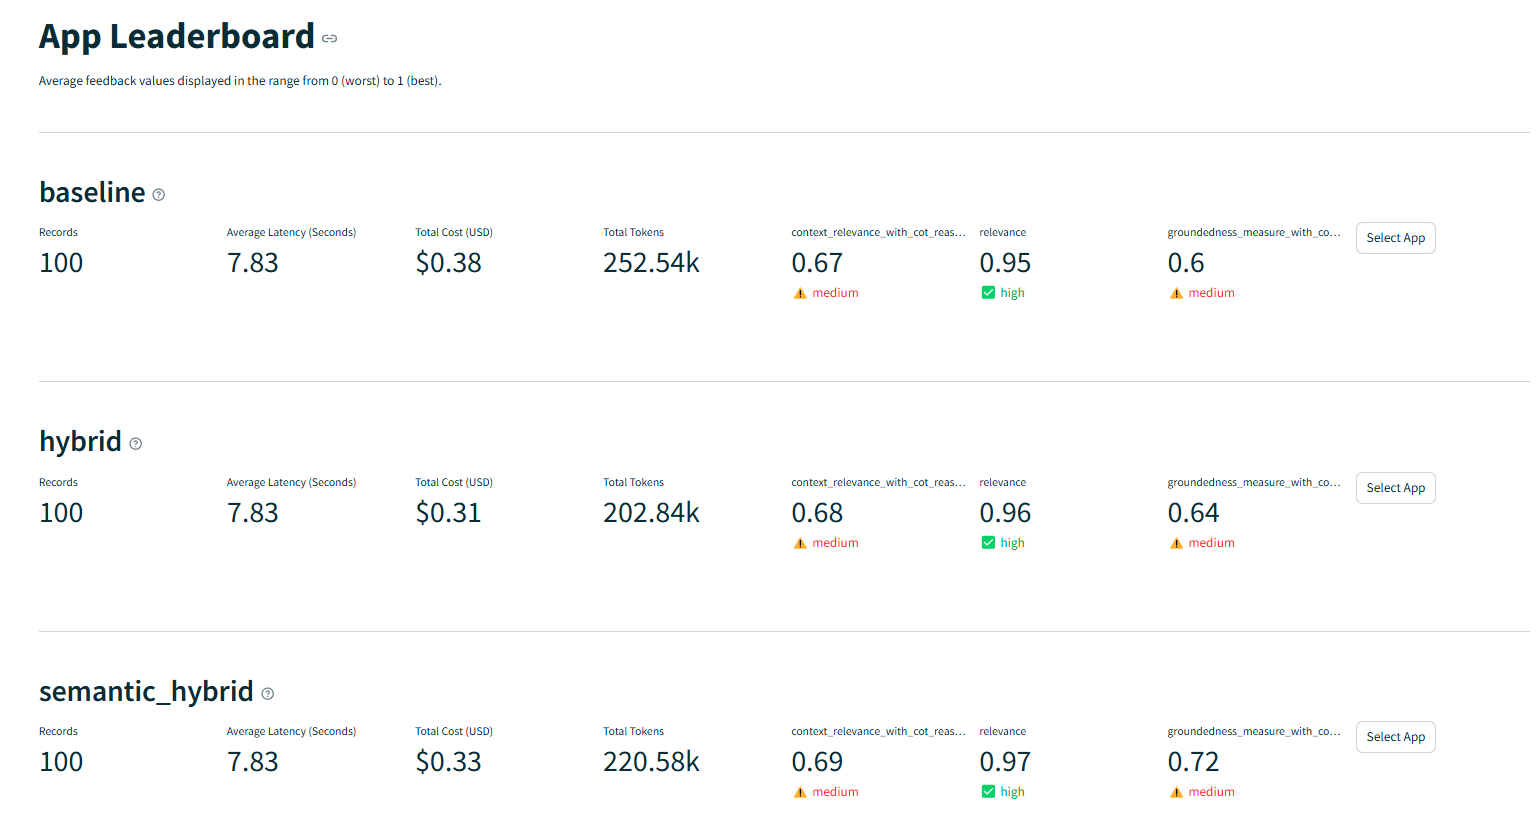

The dashboard provides the following key metrics for each query engine:

- **Records**: This represents the total count of queries that have been evaluated.
- **Average Latency (Seconds)**: This metric indicates the average duration required to process each query.
- **Total Cost (USD)**: This is the cumulative cost incurred for processing all the queries.
- **Total Tokens**: This is the total count of tokens that have been processed.
- **Context Relevance (with COT reasons)**: This metric assesses the relevance of the retrieved context to the input queries. A higher value signifies better relevance.
- **Relevance**: This metric measures how relevant the generated answers are to the questions asked. A higher value signifies higher relevance.
- **Groundedness Measure (with COT reasons)**: This metric evaluates the groundedness of the answers, ensuring that the responses are based on the retrieved context and not hallucinated. A higher value signifies better groundedness.

## Deep Dive into `semantic_hybrid` User Inputs and Responses

In this section, we will take a closer look at the `semantic_hybrid` evaluation results. We'll analyze the user inputs, responses, and specific queries that resulted in a low context relevance score.

### Evaluation Records for `semantic_hybrid`

The table below shows the records of user inputs, responses, and the corresponding relevance, groundedness, and context relevance scores. Notice that while most responses have high relevance scores, some have lower context relevance scores.

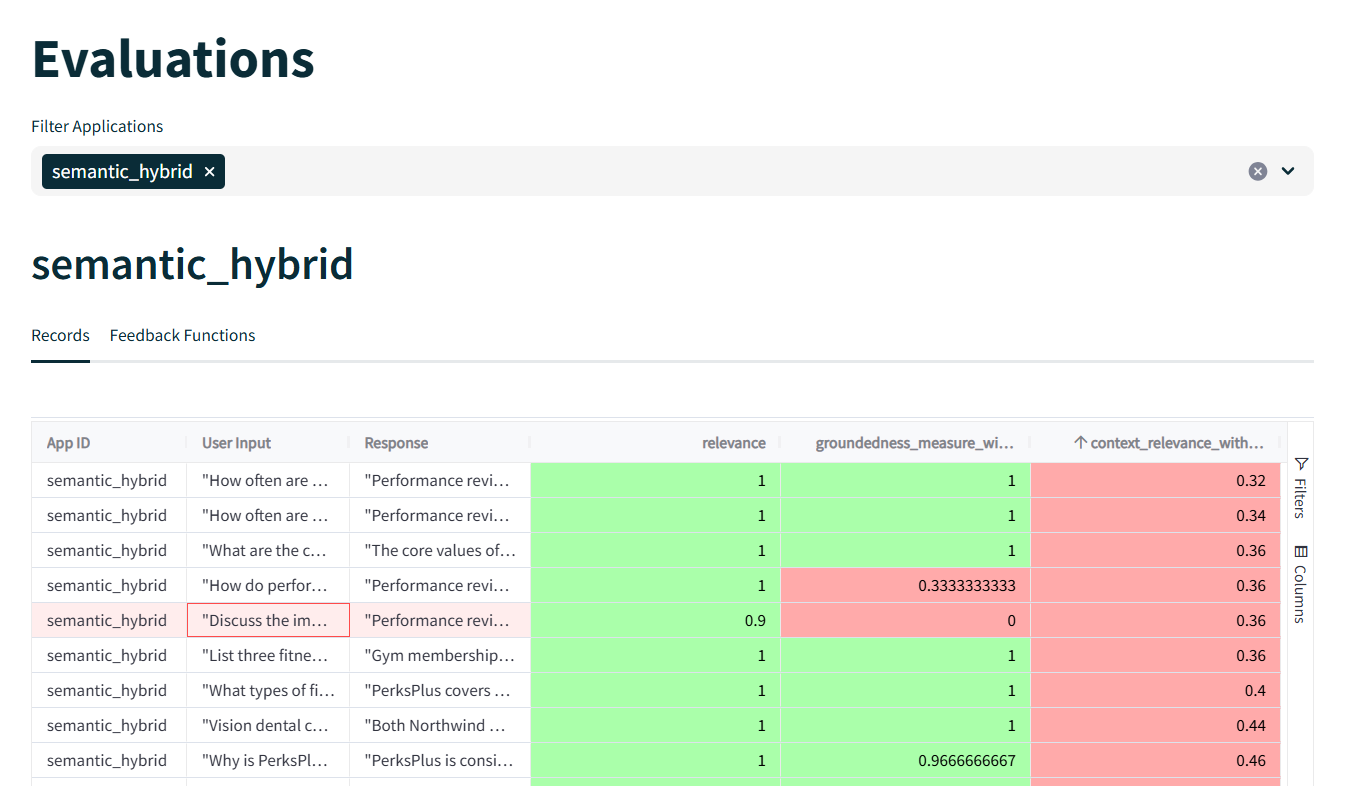

### Trace Details for a Specific Query

Here we delve into the trace details of a specific query that resulted in a low context relevance score. This helps us understand the step-by-step processing of the query and where it might have fallen short.

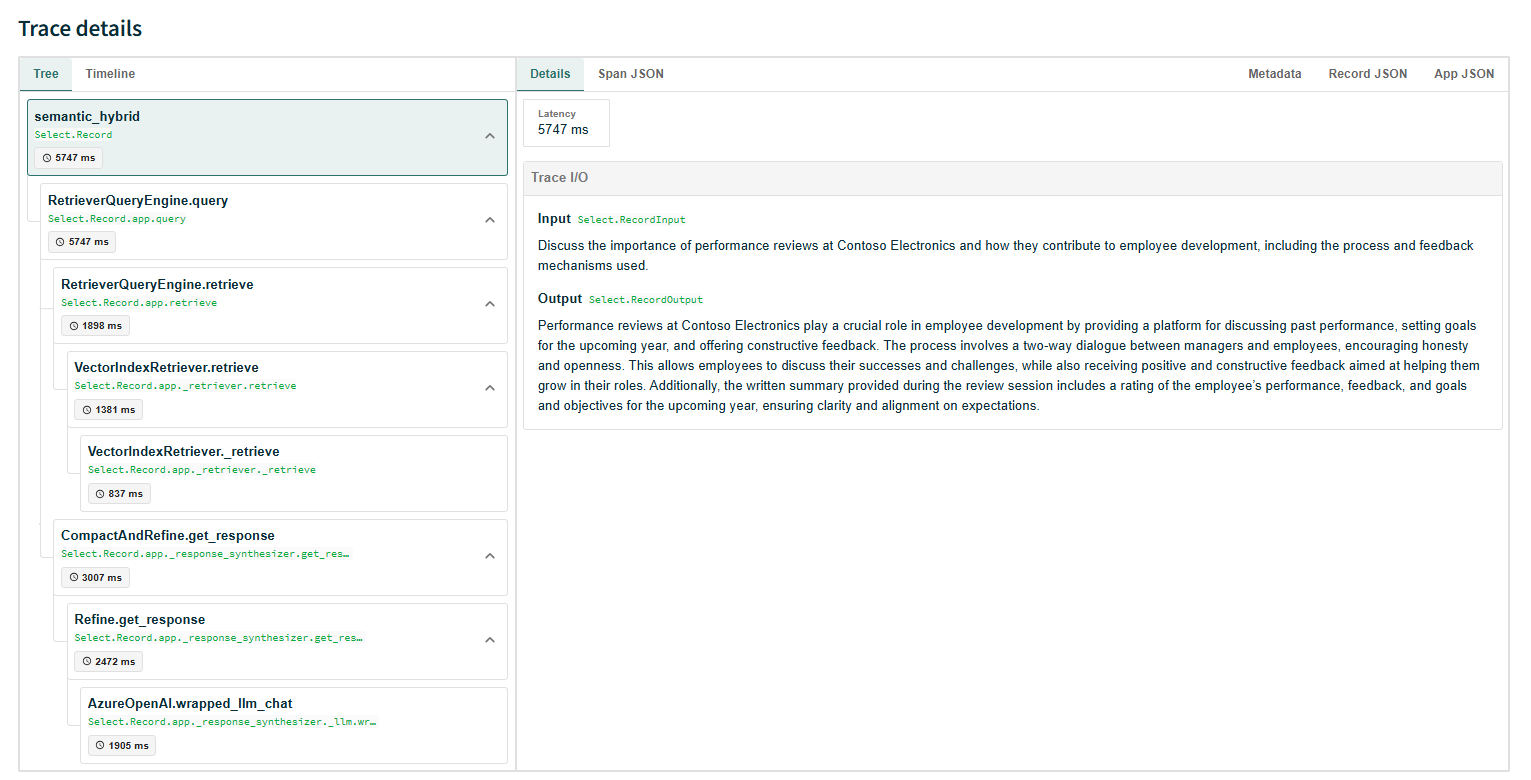

### Feedback Results for Low Context Relevance Score

The feedback results provide detailed insights into why certain queries received a low context relevance score. This analysis is crucial for identifying and rectifying issues in the retrieval and response generation process.

#### Example Query with Low Context Relevance Score

- **User Input**: "Discuss the importance of performance reviews."
- **Response**: "Performance reviews at Contoso Electronics play a crucial role in employee development by providing a platform for discussing past performance, setting goals for the upcoming year, and offering constructive feedback. The process involves a two-way dialogue between managers and employees, encouraging honesty and openness. This allows employees to discuss their successes and challenges, while also receiving positive and constructive feedback aimed at helping them grow in their roles. Additionally, the written summary provided during the review session includes a rating of the employee's performance, feedback, and goals and objectives for the upcoming year, ensuring clarity and alignment on expectations."

The context relevance score for this response is low because the retrieved context did not sufficiently align with the user query.

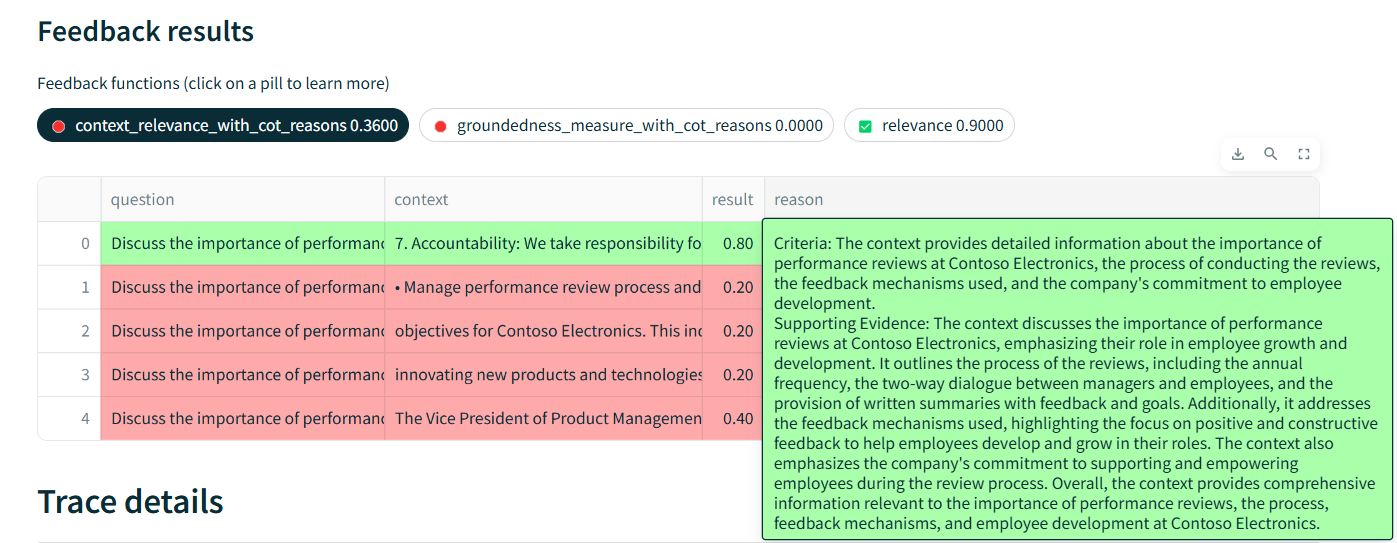

#### Criteria for Low Context Relevance Score

- **Criteria**: The context provided does not discuss the importance of performance reviews at Contoso Electronics or how they contribute to employee development, including the process and feedback mechanisms used.
- **Supporting Evidence**: The context mainly focuses on the responsibilities and qualifications of the Director of Research and Development at Contoso Electronics. It does not provide any information about the importance of performance reviews, their contribution to employee development, or the process and feedback mechanisms used at the company. Therefore, the relevance to the given question is minimal.

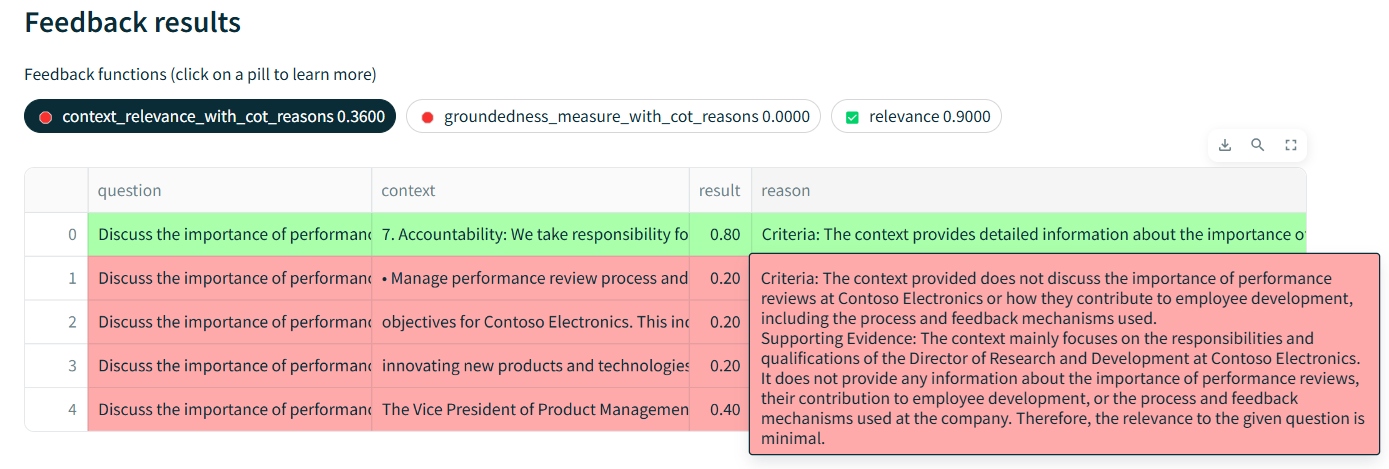




## Conclusion

Through detailed analysis of the metrics and trace details, we've identified potential areas for improvement in both the retrieval and response generation processes. This in-depth examination enables us to enhance the context relevance and overall performance of the `semantic_hybrid` retrieval mode.

To further improve these evaluation metrics, we can experiment with advanced RAG strategies such as:

- Adjusting the Chunk Size
- Modifying the Overlap Window
- Implementing a Sentence Window Retreival
- Utilizing an Auto-Merging Retreival
- Applying Query Rewriting techniques
- Experimenting with Different Embedding Models
- Testing Different Large Language Models (LLMs)

For additional information on query categorization and performance metrics, please refer to the [Azure AI Search blog post](https://techcommunity.microsoft.com/t5/ai-azure-ai-services-blog/azure-ai-search-outperforming-vector-search-with-hybrid/ba-p/3929167).